## bkilt = w1(st+1 - ts)2 + w2(rt1 - tr1)2 + w3(rt2 - tr2)2 +w4(rt2 - tr2)2+ w5(hp-tp)2
## 1. calclulate flood control strorage
## 2. calculate drinking + industrial water demand
## 3. calculate irrigation demand
## 4. calculate hydropower production and decide firm power

# 1. calclulate flood control strorage

## import all packages and provide path for the streamflow, irrigation and domestic water demands

In [6]:
pwd

'/home/udit/Desktop/Data_MIR_students/PhD/Divya/divya_data/Codes_for_the_uploading'

In [8]:
import pandas as pd
import numpy as np
import xarray as xr
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from math import sqrt

from matplotlib import gridspec
from tqdm import tqdm
import itertools
from scipy.stats import binned_statistic
import glob
import warnings
import netCDF4
import os
from netCDF4 import Dataset
warnings.filterwarnings('ignore')
%matplotlib inline
pwd_path = os.getcwd()
w1 = 0.2
w2 = 0.2
w3 = 0.2
w4 = 0.2
w5 = 0.2
# Provide path for the data 
# path1_SSDP_data = '/home/udit/Desktop/Data_MIR_students/PhD/Divya/divya_data/SSDP_MME_MICE_for_different_cases_final/'
# streamflow_SSP585_calculation = '/media/udit/Expansion1/PHD_work/hydropower_work/SSP585_calculation/'
# streamflow_SSP245_calculation_MICE = '/media/udit/Expansion1/PHD_work/hydropower_work/Hydropower_MICE_calculation_divya/hydropower_papers/Final_hydropower_data_figures/Narmada_calculation_data/rout_result_narmada/internal_rout_nar_without_biascorrection'
# streamflow_SSP245_calculation_MME = '/media/udit/Expansion1/PHD_work/hydropower_workhydropower_MME_calculations/Multimodal_uncertainity_result/Multimodal_routing/without_biascorrected/nar/'
path_irrigation_demand_ssp245_historical_MME = 'MME_avg_monthly_cropwater_requirement_cubicmeters_historical_all_realisations.nc'
path_irrigation_demand_ssp245_RCP245_MME ='MME_avg_monthly_cropwater_requirement_cubicmeters_rcp245_all_realisations.nc'
# streamflow_MME_ssp245 = xr.open_dataset(path1_SSDP_data + 'streamflow_full_montlhy_term_all_initial_condition_narmada_MME_ssp245.nc')
streamflow_MICE_ssp245 = xr.open_dataset('streamflow_full_montlhy_term_all_initial_condition_narmada_MICE_ssp245.nc')
# streamflow_MME_ssp585 = xr.open_dataset(path1_SSDP_data + 'streamflow_full_term_all_initial_condition_narmada_MME_ssp585.nc')
# streamflow_MICE_ssp585 = xr.open_dataset(path1_SSDP_data +'streamflow_full_term_all_initial_condition_narmada_MICE_ssp585.nc')


# Functions for binning analysis

In [9]:
#equal frequency  
def equifreq(arr1, m):     
    a = len(arr1)  
    n = int(a / m)  
    arr_equal = []
    for i in range(0, m):  
        arr = []  
        for j in range(i * n, (i + 1) * n):  
            if j >= a:  
                break  
            arr = arr + [arr1[j]]  
        arr_equal.append(arr)
    #print(arr_equal)
    return arr_equal    
           
# equal width  
def equiwidth(arr1, m):  
    a = len(arr1) 
    print(max(arr1))
    print(min(arr1))
    print(m)
    w = (max(arr1) - min(arr1)) / m 
    print(w)
    min1 = min(arr1)  
    arr_equalwidth = []
    arr = []  
    #print(arr1)
    for i in range(0, m + 1):  
        #print(i)
        #print(arr)
        #print(min1)
       # print(w)
       # print(i)
        arr = arr + [min1 + w * i] 
       # print(arr)
    arri=[]  
       
    for i in range(0, m):  
        temp = []  
        for j in arr1:  
            if j >= arr[i] and j <= arr[i+1]:  
                temp += [j]  
        arri += [temp]  
        arr_equalwidth.append(arri)  
    return(arr_equalwidth)

def equal_frequency_ploting(inflow_full_monthly,m):
    y_data = inflow_full_monthly['streamflow']
    data = (np.array(y_data.values))

    #data = np.reshape(data, [:1])
    shape1 = np.shape(data)
    shape1[1]
    data = np.reshape(data, (shape1[1]*shape1[0]*shape1[2]))
    data = np.sort(data)
    data
    data1 = list(filter(lambda x: str(x) != 'nan', data))
    data = list(filter(lambda x: (x) > 0, data1))
    # no of bins  
    #m = 20

    print("equal frequency binning")  
    arr_equal = equifreq(data, m)  
    # equal frequency binning
    limits11_1 = []
    for limits1 in tqdm(itertools.islice(range(len(arr_equal)),0,None,1)):
        limits11 = [arr_equal[limits1][0], arr_equal[limits1][-1]]
        #print(limits11)
    bins_list = [arr_equal[0][0]]
    for n in range(m):
        bins_list.append(arr_equal[n][-1])
    pd.Series(data).plot(kind='hist', bins=bins_list)
    plt.ylabel('Frequency')
    plt.title('equal frequency binning')
    plt.xlabel('Inflow')
    
def equal_width_ploting(inflow_full_monthly,m):
    y_data = inflow_full_monthly['streamflow']
    data = (np.array(y_data.values))

    #data = np.reshape(data, [:1])
    shape1 = np.shape(data)
    shape1[1]
    data = np.reshape(data, (shape1[1]*shape1[0]*shape1[2]))
    data = np.sort(data)
    data
    data1 = list(filter(lambda x: str(x) != 'nan', data))
    data = list(filter(lambda x: (x) > 0, data1))
    # no of bins  
    #m = 20
    print("\n\nequal width binning")  
    arr_equalwidth = equiwidth(data, m)  
    # # equal width binning
    limits11_1 = [arr_equalwidth[0][0][0]]
    for limits1 in tqdm(itertools.islice(range(len(arr_equalwidth[0])),0,None,1)):
        #print(limits1)
        if len(arr_equalwidth[0][limits1]) >0:
            limits11 = [arr_equalwidth[0][limits1][0], arr_equalwidth[0][limits1][-1]]
            limits11_1.append(arr_equalwidth[0][limits1][-1])
    bins_equalwidth = limits11_1   
    pd.Series(data).plot(kind='hist', bins=bins_equalwidth)
    plt.ylabel('Frequency')
    plt.title('equal width binning')
    plt.xlabel('Inflow')

def binning_ploting(inflow_full_monthly,bins1):
    y_data = inflow_full_monthly['streamflow']
    data = (np.array(y_data.values))

    #data = np.reshape(data, [:1])
    shape1 = np.shape(data)
    shape1[1]
    data = np.reshape(data, (shape1[1]*shape1[0]*shape1[2]))
    data = np.sort(data)
    data
    data1 = list(filter(lambda x: str(x) != 'nan', data))
    data = list(filter(lambda x: (x) > 0, data1))
    pd.Series(data).plot(kind='hist', bins=bins1)
    plt.ylabel('Frequency')
    plt.title('Balanced (considered) binning')
    plt.xlabel('Inflow')

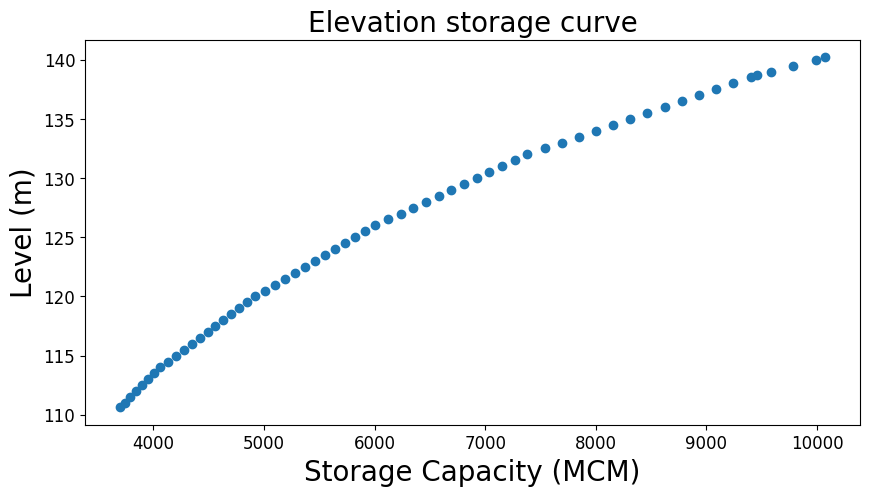

0.9998864687231286


3682410120.6900525

In [13]:
months = (['January','February','March','April','May','June','July','August','September','October','November','December'])
## Data taken from https://www.sardarsarovardam.org/document/pagecontent/FM%202022.pdf (page 75-76)
## (Disaster Management Plan - 2022) published by Sardar Sarovar Narmada Nigam Limited¶
## (page 74-76)
dfs2 = pd.read_excel('storage_level_modified_data.xlsx')

rcParams['figure.figsize']=10,5
plt.close('all')
plt.rcParams.update({'font.size': 12})
pyplot.scatter(dfs2['Capacity (MCM)'],dfs2['Level'])
plt.xlabel('Storage Capacity (MCM)',fontsize=20)
plt.ylabel('Level (m)',fontsize=20)
plt.title('Elevation storage curve',fontsize=20)

#plt.savefig("Elevation_storage_curve_ssp_new.png",dpi  = 300)
plt.show()
linreg = LinearRegression()
#sns.regplot(ssp_level_storage['storage(BCM)'],ssp_level_storage['level(m)'], fit_reg = True)
#sns.regplot(avg_storage,avg_level, fit_reg = True)
#sns.regplot(dfs2['Capacity (MCM)'],dfs2['Level'], order = 3, fit_reg = True, color = 'red')
mymodel = np.poly1d(np.polyfit(dfs2['Capacity (MCM)'],dfs2['Level'], 3))
mymodel # y = ax3 + bx2 + cx +d for order 3
print(r2_score(dfs2['Level'], mymodel(dfs2['Capacity (MCM)'])))

# target storage as live capacity as 0.58 M. ha. m = 0.58 * 10000 Mm3 (McM) = 0.58 * 10 BcM (billoin cubic meters)
Target_storage = 5800 * 10**6 # in 5800 MCM = 5800 * 10**6

def class_representative(n, bmin, bmax):
# n = 4
# bmin = 2
# bmax = 10
    b = [bmin]
    b_class = []
    for i in range(n):
        b1 = (bmax - bmin)/n
        b2 =  b[-1] + b1
        b.append(b2)
        b3 = (b[-1] + b[-2])/2
        b_class.append(b3)
        #print(b_class)
       # print(b)
    return [b_class, b]
mymodel1 = np.poly1d(np.polyfit(dfs2['Level'],dfs2['Capacity (MCM)'], 3))
drawdown_level =  110.64 
FRL_level =  138.68
class_storage = 10
min_storage =  (mymodel1[0] + (mymodel1[1]*drawdown_level) + (mymodel1[2]*drawdown_level*drawdown_level) + (mymodel1[3]*drawdown_level*drawdown_level*drawdown_level)) * 10**6
max_storage =  (mymodel1[0] + (mymodel1[1]*FRL_level) + (mymodel1[2]*FRL_level*FRL_level) + (mymodel1[3]*FRL_level*FRL_level*FRL_level))* 10**6
[storage_class_representative, storage_class] = class_representative(class_storage, min_storage, max_storage)
min_storage

## flood control levels

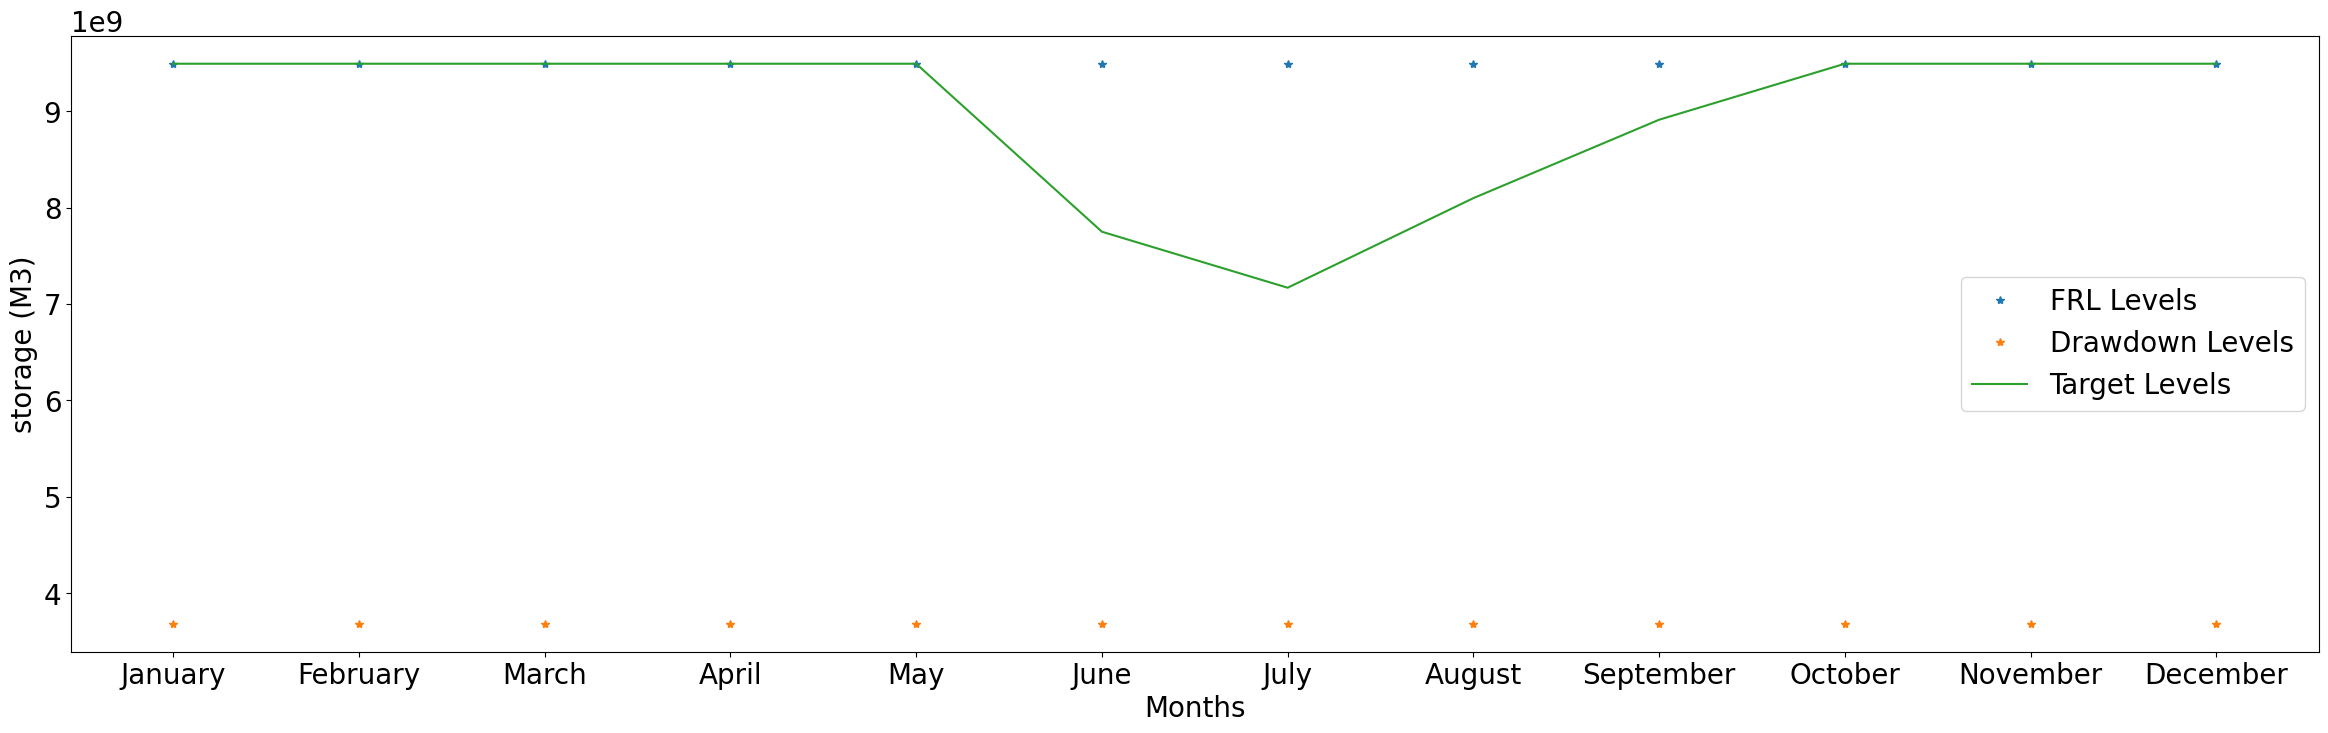

In [16]:
## https://www.sardarsarovardam.org/document/pagecontent/FM%202022.pdf
## page 65
FRL_levels = [max_storage,max_storage,max_storage,max_storage,max_storage,max_storage, max_storage,max_storage,max_storage,max_storage,max_storage,max_storage]
Drawdown_levels = [min_storage,min_storage,min_storage,min_storage,min_storage,min_storage, min_storage,min_storage,min_storage,min_storage,min_storage,min_storage]
difference = max_storage -  min_storage
mon_1 = min_storage +difference * 1
mon_2 = min_storage +difference * 1
mon_3 = min_storage +difference * 1
mon_4 = min_storage +difference * 1
mon_5 = min_storage +difference * 1
mon_6 = min_storage + difference * 0.7
mon_7 = min_storage +difference * 0.6
mon_8 = min_storage +difference * 0.76
mon_9 = min_storage +difference * 0.9
mon_10 = min_storage +difference * 1
mon_11 = min_storage +difference * 1
mon_12 = min_storage + difference * 1
target_monsoon_storage = [mon_1, mon_2,mon_3,mon_4,mon_5,mon_6,mon_7, mon_8,mon_9,mon_10,mon_11,mon_12]
target_monsoon_storage
rcParams['figure.figsize']=29,8
plt.close('all')
plt.rcParams.update({'font.size': 20})
plt.plot(months, FRL_levels,'*', label = 'FRL Levels')
plt.plot(months, Drawdown_levels,'*', label = 'Drawdown Levels')
plt.plot(months,target_monsoon_storage, label = 'Target Levels')
plt.xlabel('Months',fontsize=20)
plt.ylabel('storage (M3)',fontsize=20)
plt.legend()

#plt.savefig("Target_storage_level_for_flood control.png",dpi  = 600)
plt.show()

# 2. calculate drinking water demand

In [17]:
# Yearly water demand extracted by figure from 'Estimation of industrial water demand in India using census-based statistical data'
# (https://www.sciencedirect.com/science/article/pii/S0022169420303905#t0010 )
# extracted data using the https://apps.automeris.io/wpd/ of figure A6 for industrial water use estimate

# # link for census data https://censusindia.gov.in/census.website/data/census-tables for population data for drinking water calculation
# Cauchois, A. (2016). Measuring the invisible: exploiting the water-energy nexus to estimate private, urban groundwater draft (No. 619-2021-1578). Reference for lpcd water demand
# reference for 150 lpcd is Grover, A. R. (2017). Evaluation of norms and standards for domestic water use in Indian cities. American Journal of Sustainable Cities and Society, 1(6), 44-55.
# reference 2- Mehta, M., Mehta, D., & Vavaliya, J. (2021). Urban drinking water security in Gujarat. Journal of Social and Economic Development, 23(1), 166-180.
# 3 - Kaur, S., & Gauttam, P. (2022). Water Security in India: Exploring the Challenges and Prospects. Nontraditional Security Concerns in India, 211-232.
# 4. Chouhan, S., & Iyer, M. Electrical energy consumption in municipal services. 

# In literature, industrial water deamand is estimated using the multivariate linear regression (Estimation of industrial water demand in India using census-based statistical data)
# 2. Comparison of multiple linear and nonlinear regression, autoregressive integrated moving average, artificial neural network, and wavelet artificial neural network methods for urban water demand forecasting in Montreal, Canada
# 3. REference for ARIMA - Industrial water consumption forecasting based on combined CEEMD-ARIMA model for Henan province, central chain: A case study
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ 

# assumed 150 lpcd as drinking water demand (municipal water requirement)

workbook = pd.read_csv(path2 + "population_gujarat_data1_final.csv")
workbook1 = workbook.set_index(['District', 'year']).to_xarray()
districts = workbook1['District'].values
years = workbook1['year'].values

# Narmada Canal based drinking water supply project was taken up in the State to cover about 75 percent population of the State through a State Wide Drinking Water Grid.
# https://sardarsarovardam.org/water-supply-policy.aspx                                                                    


df = pd.DataFrame({'districts':[],'avg_increment':[],'avg_incremental_increase': [], '2021_pop': [],'2031_pop': [],'2041_pop': [],'2051_pop':[],'2061_pop': [],'2071_pop': [],'2081_pop': [],'2091_pop':[],'2101_pop': []})

for i in range(len(districts)):
    print(districts[i])
    if districts[i] == 'Kachchh':
        b = (workbook1['Persons'].sel(District = districts[i])).str.replace(',', '').astype(float)
    else:
        b = (workbook1['Persons'].sel(District = districts[i])).str.replace(',', '').astype(float)
    District = districts[i]
    c = []
    for j in range(1,len(b)):
        c1 = b[j] - b[j-1]
        c.append(c1.values)
    increment = np.mean(c)
    
    d = []
    for j in range(1,len(c)):
        c1 = c[j] - c[j-1]
        d.append(c1)
    incremental_increase = np.mean(d)
    p1 = (workbook1['Persons'].sel(District = districts[i], year =2011)).str.replace(',', '').astype(float).values
    p_2021 = p1 +(1*increment) + ((1*2)/2)*incremental_increase
    p_2031 = p1 +(2*increment) + ((3*2)/2)*incremental_increase
    p_2041 = p1 +(3*increment) + ((3*4)/2)*incremental_increase
    p_2051 = p1 +(4*increment) + ((4*5)/2)*incremental_increase
    p_2061 = p1 +(5*increment) + ((5*6)/2)*incremental_increase
    p_2071 = p1 +(6*increment) + ((6*7)/2)*incremental_increase
    p_2081 = p1 +(7*increment) + ((7*8)/2)*incremental_increase
    p_2091 = p1 +(8*increment) + ((8*9)/2)*incremental_increase
    p_2101 = p1 +(9*increment) + ((9*10)/2)*incremental_increase
    df = df.append({'districts':District,'avg_increment':increment,'avg_incremental_increase': incremental_increase, '2021_pop': p_2021,'2031_pop':p_2031,'2041_pop':p_2041,'2051_pop':p_2051,'2061_pop':p_2061,'2071_pop':p_2071,'2081_pop':p_2081,'2091_pop':p_2091,'2101_pop': p_2101},ignore_index=True)

df1 = df.set_index(['districts']).to_xarray()
df1.to_netcdf('drinking_water_requirement.nc')

df1 = pd.DataFrame({'year':[],'population':[],'Drinking_water_demand':[]})
abc = xr.open_dataset(path2 +'drinking_water_requirement.nc')
years1 = np.arange(1901, 2101, 1)
years_1 = np.arange(1901, 2012, 1)
years_2 = np.arange(2012, 2101, 1)
year_3 = [2021,2031,2041,2051,2061,2071,2081,2091,2101]
months = np.arange(1, 13, 1)
for i,j in enumerate(years_1):
    if years_1[i] ==1901:
        population1 = workbook1['Persons'].sel(year = 1901).str.replace(',', '').astype(float).sum().values
        Drinking_water_demand1 = (population1 * 0.75) * (135/1000) * 30
        #industrial_water_demand1 = population1 * (47/1000) * 30
        #drinking_industrial_demand1 = Drinking_water_demand1 + industrial_water_demand1
        df1 = df1.append({'year':years_1[i],'population':population1,'Drinking_water_demand':Drinking_water_demand1},ignore_index=True)
   
    else:
        for k in range(len(years)-1):
            if years_1[i] > years[k] and years_1[i] <= years[k+1]:
                population1 = workbook1['Persons'].sel(year = years[k+1]).str.replace(',', '').astype(float).sum().values
                Drinking_water_demand1 = (population1 * 0.75) * (135/1000) * 30
                #industrial_water_demand1 = population1 * (47/1000) * 30
                #drinking_industrial_demand1 = Drinking_water_demand1 + industrial_water_demand1
                df1 = df1.append({'year':years_1[i],'population':population1,'Drinking_water_demand':Drinking_water_demand1},ignore_index=True)

for i,j in enumerate(years_2):
    #print(years_2[i])
    for k in range(len(years1)-1):
        #print(years_2[i])
        #print(years1[k])
        if years_2[i] > years1[k] and years_2[i] <= years1[k+1]:
            if years_2[i] <= year_3[0]:
                print(years_2[i])
                population1 = abc['2021_pop'].sum().values
            elif years_2[i] > year_3[0] and years_2[i] <= year_3[1]:
                print(years_2[i])
                population1 = abc['2031_pop'].sum().values
            elif years_2[i] > year_3[1] and years_2[i] <= year_3[2]:
                print(years_2[i])
                population1 = abc['2041_pop'].sum().values
            elif years_2[i] > year_3[2] and years_2[i] <= year_3[3]:
                print(years_2[i])
                population1 = abc['2051_pop'].sum().values
            elif years_2[i] > year_3[3] and years_2[i] <= year_3[4]:
                print(years_2[i])
                population1 = abc['2061_pop'].sum().values
            elif years_2[i] > year_3[4] and years_2[i] <= year_3[5]:
                print(years_2[i])
                population1 = abc['2071_pop'].sum().values
            elif years_2[i] > year_3[5] and years_2[i] <= year_3[6]:
                print(years_2[i])
                population1 = abc['2081_pop'].sum().values
            elif years_2[i] > year_3[6] and years_2[i] <= year_3[7]:
                print(years_2[i])
                population1 = abc['2091_pop'].sum().values
            elif years_2[i] > year_3[7] and years_2[i] <= year_3[8]:
                print(years_2[i])
                population1 = abc['2101_pop'].sum().values
            Drinking_water_demand1 = (population1 * 0.75) * (135/1000) * 30
            #industrial_water_demand1 = population1 * (47/1000) * 30
            #drinking_industrial_demand1 = Drinking_water_demand1 + industrial_water_demand1
            df1 = df1.append({'year':years_2[i],'population':population1,'Drinking_water_demand':Drinking_water_demand1},ignore_index=True)

df2 = df1.set_index(['year'])
df3 = df2.to_xarray()
df3.to_netcdf('drinking_water_requirements_1901_2101_data.nc')

21

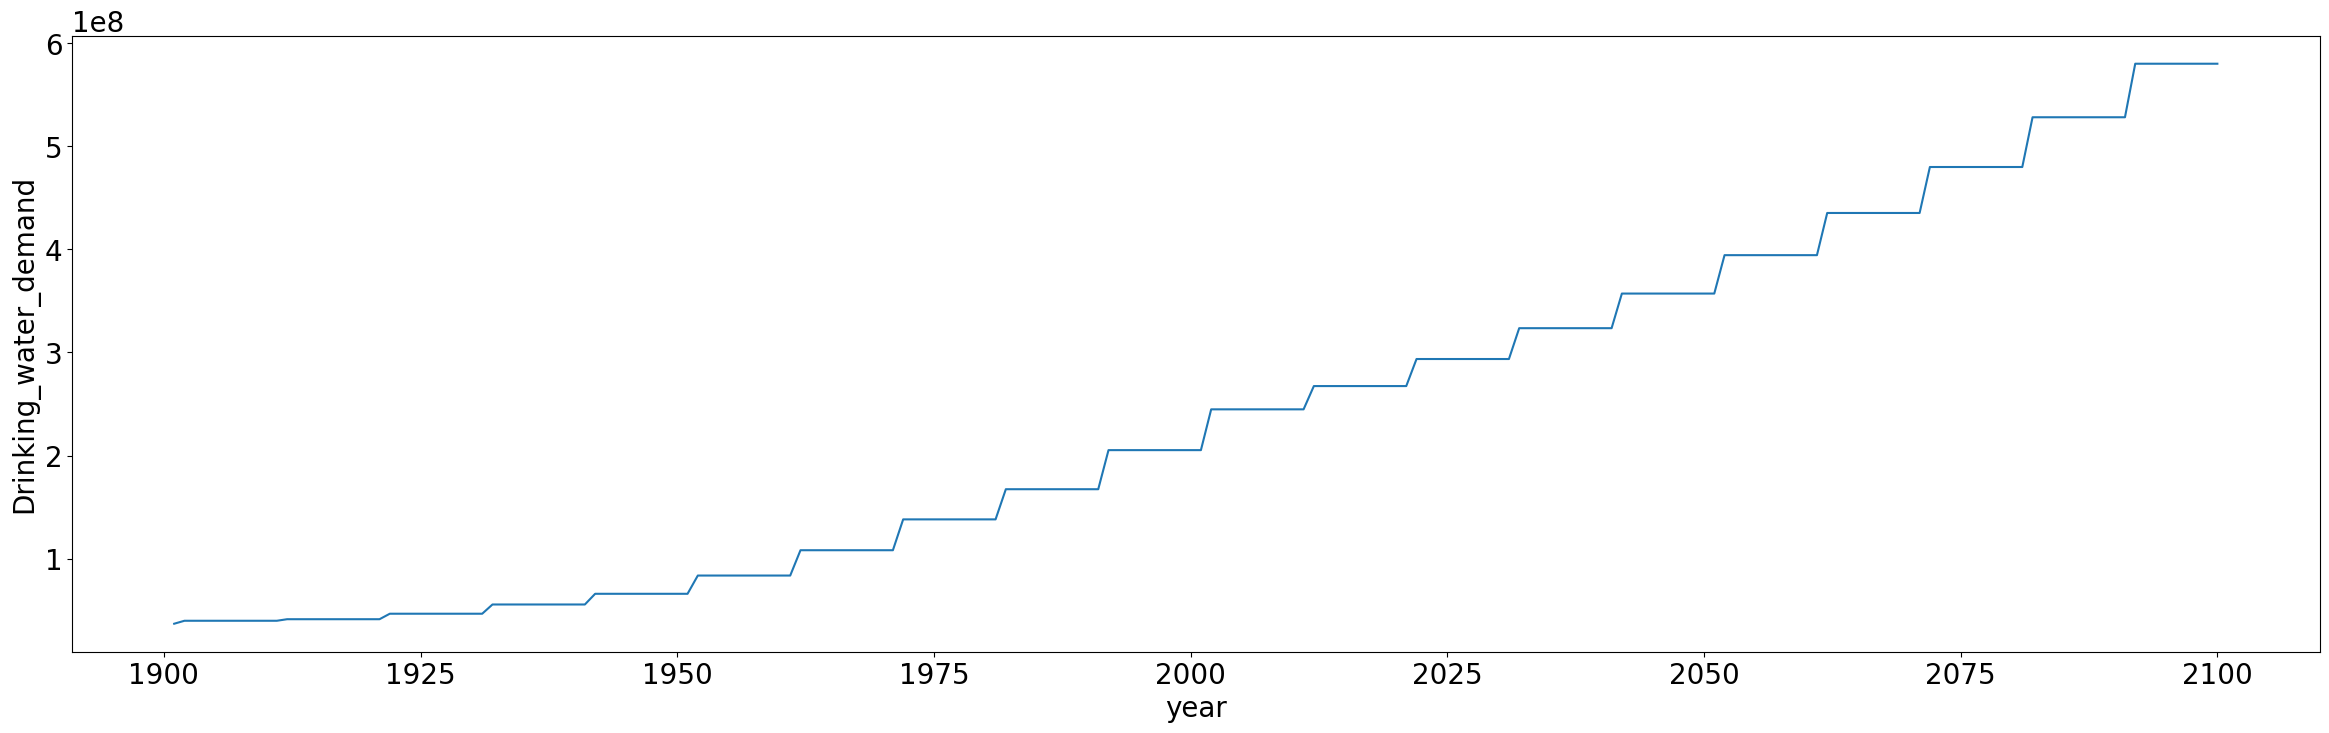

In [19]:
drinking_water_1 = xr.open_dataset('drinking_water_requirements_1901_2101_data.nc')
drinking_water_data = np.unique(drinking_water_1['Drinking_water_demand'])
drinking_water_1['Drinking_water_demand'].plot()
drinking_water_classes = np.unique(drinking_water_1['Drinking_water_demand'])
len(drinking_water_classes)

In [20]:
# The water available from Sardar Sarovar Dam has been utilized for irrigation, domestic and industrial purposes under Phase-I & II of the Sardar Sarovar Project Command. 
# http://nca.gov.in/forms_pdf/annual-report/annal-report-english-2020-21.pdf
# we have considred the 246.7 MCM as allocated for municipal use

# binning analysis for storage classes

# data downloaded from India waris storage and level data for sardar sarovar dam
dfs = pd.read_csv('modified_storage_level.csv')
#dfs['Current Year Storage (BCM)'].plot()
plt.rcParams.update({'font.size':25})
sns.set_style('whitegrid')
#projection = ccrs.Orthographic(-90, 85)
fig = plt.figure(figsize= (20,8))
gs = gridspec.GridSpec(1,2)
ax1 = fig.add_subplot(gs[0])
dfs['Current Live Storage'].plot()
plt.ylabel('Live storage (BCM)')

ax2 = fig.add_subplot(gs[1])
print(dfs['Current Live Storage'].max())
dfs['Level'].plot()
plt.ylabel('Level (m)')

dfs = pd.read_csv('modified_storage_level.csv')
x_data = np.arange(0, len(dfs))
y_data = dfs['Current Live Storage']

# data to be binned  
data = (np.array(y_data.values))
data = np.sort(data) 
data1 = list(filter(lambda x: str(x) != 'nan', data))
data = list(filter(lambda x: (x) > 0, data1))
# no of bins  
m = 20
   
print("equal frequency binning")  
arr_equal = equifreq(data, m)  
   
print("\n\nequal width binning")  
arr_equalwidth = equiwidth(data, 20)  

# plotting
plt.rcParams.update({'font.size':25})
sns.set_style('whitegrid')
#projection = ccrs.Orthographic(-90, 85)
fig = plt.figure(figsize= (35,8))
gs = gridspec.GridSpec(3,1)
ax1 = fig.add_subplot(gs[0])
# equal frequency binning
limits11_1 = []
for limits1 in tqdm(itertools.islice(range(len(arr_equal)),0,None,1)):
    limits11 = [arr_equal[limits1][0], arr_equal[limits1][-1]]
    #print(limits11)
#pd.Series(data).plot(kind='hist', bins=[arr_equal[0][0],arr_equal[0][-1],arr_equal[1][-1],arr_equal[2][-1],arr_equal[3][-1],arr_equal[4][-1],arr_equal[5][-1],arr_equal[6][-1],arr_equal[7][-1],arr_equal[8][-1],arr_equal[9][-1]])
pd.Series(data).plot(kind='hist', bins=[arr_equal[0][0],arr_equal[0][-1],arr_equal[1][-1],arr_equal[2][-1],arr_equal[3][-1],arr_equal[4][-1],arr_equal[5][-1],arr_equal[6][-1],arr_equal[7][-1],arr_equal[8][-1],arr_equal[9][-1],arr_equal[10][-1],arr_equal[11][-1],arr_equal[12][-1],arr_equal[13][-1],arr_equal[14][-1],arr_equal[15][-1],arr_equal[16][-1],arr_equal[17][-1],arr_equal[18][-1],arr_equal[19][-1]])
plt.ylabel('Frequency')
plt.title('equal frequency binning')
plt.xlabel('Storage')
# # equal width binning
ax2 = fig.add_subplot(gs[1])
limits11_1 = []
for limits1 in tqdm(itertools.islice(range(len(arr_equalwidth[0])),0,None,1)):
    limits11 = [arr_equalwidth[0][limits1][0], arr_equalwidth[0][limits1][-1]]
    #print(limits11)
pd.Series(data).plot(kind='hist', bins=[arr_equalwidth[0][0][0],arr_equalwidth[0][0][-1],arr_equalwidth[0][1][-1],arr_equalwidth[0][2][-1],arr_equalwidth[0][3][-1],arr_equalwidth[0][4][-1],arr_equalwidth[0][5][-1],arr_equalwidth[0][6][-1],arr_equalwidth[0][7][-1],arr_equalwidth[0][8][-1],arr_equalwidth[0][9][-1],arr_equalwidth[0][10][-1],arr_equalwidth[0][11][-1],arr_equalwidth[0][12][-1],arr_equalwidth[0][13][-1],arr_equalwidth[0][14][-1],arr_equalwidth[0][15][-1],arr_equalwidth[0][16][-1],arr_equalwidth[0][17][-1],arr_equalwidth[0][18][-1],arr_equalwidth[0][19][-1]])
plt.ylabel('Frequency')
plt.title('equal width binning')
plt.xlabel('Storage')

# considered for the analysis
ax3 = fig.add_subplot(gs[2])
pd.Series(data).plot(kind='hist', bins=[0.002,0.3,0.45,0.6,0.75,0.9,1.05,1.14
                                        ,1.2,1.3,1.37, 1.42, 1.48, 1.535, 1.57,2,2.5, 3.01823,3.5, 3.991,4.4,4.8,5, 5.4, 5.65,5.76])
plt.ylabel('Frequency')
plt.title('Balanced (considered) binning')
plt.xlabel('Storage')
bins=[0.002,0.3,0.45,0.6,0.75,0.9,1.05,1.14
                                        ,1.2,1.3,1.37, 1.42, 1.48, 1.535, 1.57,2,2.5, 3.01823,3.5, 3.991,4.4,4.8,5, 5.4, 5.65,5.76]
#plt.savefig('storage_classes.png')

len(bins)

In [21]:
#streamflow_MME_ssp245 = xr.open_dataset('streamflow_full_montlhy_term_all_initial_condition_narmada_MME_ssp245.nc')
streamflow_MICE_ssp245 = xr.open_dataset('streamflow_full_montlhy_term_all_initial_condition_narmada_MICE_ssp245.nc')
# streamflow_MME_ssp585 = xr.open_dataset('streamflow_full_term_all_initial_condition_narmada_MME_ssp585.nc')
# streamflow_MICE_ssp585 = xr.open_dataset('streamflow_full_term_all_initial_condition_narmada_MICE_ssp585.nc')

In [ ]:
# data to be binned 
# plotting
plt.rcParams.update({'font.size':25})
sns.set_style('whitegrid')
#projection = ccrs.Orthographic(-90, 85)
fig = plt.figure(figsize= (55,30))
gs = gridspec.GridSpec(4,3)
ax1 = fig.add_subplot(gs[0])
inflow_full_monthly= streamflow_MME_ssp245
equal_frequency_ploting(inflow_full_monthly,40)
ax2 = fig.add_subplot(gs[1])
equal_width_ploting(inflow_full_monthly,40)
ax3 = fig.add_subplot(gs[2])
bins1 = [0,3,6,20, 50, 100,150, 200,300,400,600,800,1000,1200,1500, 2000,2700, 3500,4500, 5000,6000, 7000,8000,9400,10500,12000,15000,20000, 30000,40000,48300]
binning_ploting(inflow_full_monthly,bins1)
print(len(bins1))
ax4 = fig.add_subplot(gs[3])
inflow_full_monthly= streamflow_MICE_ssp245
equal_frequency_ploting(inflow_full_monthly,40)
ax5 = fig.add_subplot(gs[4])
equal_width_ploting(inflow_full_monthly,40)
ax6 = fig.add_subplot(gs[5])
binning_ploting(inflow_full_monthly,bins1)

ax7 = fig.add_subplot(gs[6])
inflow_full_monthly= streamflow_MME_ssp585
equal_frequency_ploting(inflow_full_monthly,40)
ax8 = fig.add_subplot(gs[7])
equal_width_ploting(inflow_full_monthly,40)
ax9 = fig.add_subplot(gs[8])
binning_ploting(inflow_full_monthly,bins1)

ax10 = fig.add_subplot(gs[9])
inflow_full_monthly= streamflow_MICE_ssp585
equal_frequency_ploting(inflow_full_monthly,40)
ax11 = fig.add_subplot(gs[10])
equal_width_ploting(inflow_full_monthly,40)
ax12 = fig.add_subplot(gs[11])
binning_ploting(inflow_full_monthly,bins1)

In [ ]:
initial_condition_list_new_MME = ['ACCESS-CM2', 'GFDL-ESM4', 'CanESM5', 'MRI-ESM2-0', 'EC-Earth3', 'NorESM2-LM']
irrigation_water_demand_historical = xr.open_dataset(path_irrigation_demand_ssp245_historical_MME)
irrigation_water_demand_RCP245 = xr.open_dataset(path_irrigation_demand_ssp245_RCP245_MME)
historical_rcp245 = [irrigation_water_demand_historical,irrigation_water_demand_RCP245]
data2 = []
for i in range(2): 
    data1 = []
    for a, list_name in tqdm(itertools.islice(enumerate(initial_condition_list_new_MME),0,None,1)):
        historical_rcp245_values = historical_rcp245[i]
        y_data = historical_rcp245_values['GIR_crop_volume_cubicmeter'].sel(realisation = list_name)
        data = (np.array(y_data.values))
        shape1 = np.shape(data)
        data = np.reshape(data, (shape1[1]*shape1[0]))
        data1.append(data)
    shape2 = np.shape(data1)
    data1 = np.reshape(data1, (shape2[1]*shape2[0]))
    #print(data1.shape)
    data2.append(data1)
irrigation_water_demand_MME_ssp245 = np.array(list(data2[0]) + list(data2[1]))

irrigation_water_demand_historical = xr.open_dataset(path_irrigation_demand_ssp245_historical_MICE)
irrigation_water_demand_RCP245 = xr.open_dataset(path_irrigation_demand_ssp245_RCP245_MICE)
historical_rcp245 = [irrigation_water_demand_historical,irrigation_water_demand_RCP245]
initial_condition_list_new_MICE = streamflow_MICE_ssp585['initial_condition'].values
data2 = []
for i in range(2): 
    data1 = []
    for a, list_name in tqdm(itertools.islice(enumerate(initial_condition_list_new_MICE),0,None,1)):
        historical_rcp245_values = historical_rcp245[i]
        y_data = historical_rcp245_values['GIR_crop_volume_cubicmeter'].sel(realisation = list_name)
        data = (np.array(y_data.values))
        shape1 = np.shape(data)
        data = np.reshape(data, (shape1[1]*shape1[0]))
        data1.append(data)
    shape2 = np.shape(data1)
    data1 = np.reshape(data1, (shape2[1]*shape2[0]))
    #print(data1.shape)
    data2.append(data1)
irrigation_water_demand_MICE_ssp245 = np.array(list(data2[0]) + list(data2[1]))

irrigation_water_demand_historical= xr.open_dataset(path_irrigation_demand_SSP585_MME+'MME_avg_monthly_cropwater_requirement_cubicmeters_historical_all_realisations.nc')
irrigation_water_demand_RCP245 = xr.open_dataset(path_irrigation_demand_SSP585_MME +'MME_avg_monthly_cropwater_requirement_cubicmeters_rcp245_all_realisations.nc')
# as Two models INM-CM4-8 and INM-CM5-0 have over estimates then the observed data (JHM figure 3). I have not considered this two models for the further analysis.
historical_rcp245 = [irrigation_water_demand_historical,irrigation_water_demand_RCP245]
data2 = []
for i in range(2): 
    data1 = []
    for a, list_name in tqdm(itertools.islice(enumerate(initial_condition_list_new_MME),0,None,1)):
        historical_rcp245_values = historical_rcp245[i]
        y_data = historical_rcp245_values['GIR_crop_volume_cubicmeter'].sel(realisation = list_name)
        data = (np.array(y_data.values))
        shape1 = np.shape(data)
        data = np.reshape(data, (shape1[1]*shape1[0]))
        data1.append(data)
    shape2 = np.shape(data1)
    data1 = np.reshape(data1, (shape2[1]*shape2[0]))
    #print(data1.shape)
    data2.append(data1)
irrigation_water_demand_MME_ssp585 = np.array(list(data2[0]) + list(data2[1]))

irrigation_water_demand_historical= xr.open_dataset(path_irrigation_demand_SSP585_MICE +'MICE_avg_monthly_cropwater_requirement_cubicmeters_historical_all_realisations.nc')
irrigation_water_demand_RCP245 = xr.open_dataset(path_irrigation_demand_SSP585_MICE +'MICE_avg_monthly_cropwater_requirement_cubicmeters_rcp245_all_realisations.nc')
# as Two models INM-CM4-8 and INM-CM5-0 have over estimates then the observed data (JHM figure 3). I have not considered this two models for the further analysis.
historical_rcp245 = [irrigation_water_demand_historical,irrigation_water_demand_RCP245]
data2 = []
for i in range(2): 
    data1 = []
    for a, list_name in tqdm(itertools.islice(enumerate(initial_condition_list_new_MICE),0,None,1)):
        historical_rcp245_values = historical_rcp245[i]
        y_data = historical_rcp245_values['GIR_crop_volume_cubicmeter'].sel(realisation = list_name)
        data = (np.array(y_data.values))
        shape1 = np.shape(data)
        data = np.reshape(data, (shape1[1]*shape1[0]))
        data1.append(data)
    shape2 = np.shape(data1)
    data1 = np.reshape(data1, (shape2[1]*shape2[0]))
    #print(data1.shape)
    data2.append(data1)
irrigation_water_demand_MICE_ssp585 = np.array(list(data2[0]) + list(data2[1]))
# # #print(data3.shape)
print(irrigation_water_demand_MME_ssp245.max())
print(irrigation_water_demand_MICE_ssp245.max())
print(irrigation_water_demand_MME_ssp585.max())
print(irrigation_water_demand_MICE_ssp585.max())


In [ ]:
def irrigation_equal_frequency(data3, m):
    data = np.sort(data3)
    data1 = list(filter(lambda x: str(x) != 'nan', data))
    data = list(filter(lambda x: (x) > 0, data1))
    data = np.array(data)/1000000  
    print(len(data))
    arr_equal = equifreq(data, m)  
    limits11_1 = []
    for limits1 in tqdm(itertools.islice(range(len(arr_equal)),0,None,1)):
        limits11 = [arr_equal[limits1][0], arr_equal[limits1][-1]]
        #print(limits11)
        
    bins_list = [arr_equal[0][0]]
    for n in range(m):
        bins_list.append(arr_equal[n][-1])
    pd.Series(data).plot(kind='hist', bins=bins_list)
    plt.ylabel('Frequency')
    plt.title('equal frequency binning')
    plt.xlabel('Storage')
    
def irrigation_equal_width(data3, m):
    data = np.sort(data3)
    data1 = list(filter(lambda x: str(x) != 'nan', data))
    data = list(filter(lambda x: (x) > 0, data1))
    data = np.array(data)/1000000  
    arr_equalwidth = equiwidth(data, m)
    limits11_1 = []
    for limits1 in tqdm(itertools.islice(range(len(arr_equalwidth[0])),0,None,1)):
        #print(arr_equalwidth)
        limits11 = [arr_equalwidth[0][limits1][0], arr_equalwidth[0][limits1][-1]]
        #print(limits11)
    pd.Series(data).plot(kind='hist', bins=[arr_equalwidth[0][0][0],arr_equalwidth[0][0][-1],arr_equalwidth[0][1][-1],arr_equalwidth[0][2][-1],arr_equalwidth[0][3][-1],arr_equalwidth[0][4][-1],arr_equalwidth[0][5][-1],arr_equalwidth[0][6][-1],arr_equalwidth[0][7][-1],arr_equalwidth[0][8][-1],arr_equalwidth[0][9][-1]])
    plt.ylabel('Frequency')
    plt.title('equal width binning')
    plt.xlabel('Storage')
    
def irrigation_binning(data3,bins1):
    data = np.sort(data3)
    data1 = list(filter(lambda x: str(x) != 'nan', data))
    data = list(filter(lambda x: (x) > 0, data1))
    data = np.array(data)/1000000
    pd.Series(data).plot(kind='hist', bins= bins1)
    plt.ylabel('Frequency')
    plt.title('Balanced (considered) binning')
    plt.xlabel('Storage')

In [ ]:
# data to be binned 
# plotting
plt.rcParams.update({'font.size':25})
sns.set_style('whitegrid')
#projection = ccrs.Orthographic(-90, 85)
fig = plt.figure(figsize= (55,30))
gs = gridspec.GridSpec(2,1)
# ax1 = fig.add_subplot(gs[0])
# irrigation_equal_frequency(irrigation_water_demand_MME_ssp245, 20)
# ax2 = fig.add_subplot(gs[1])
# irrigation_equal_width(irrigation_water_demand_MME_ssp245, 20)
ax3 = fig.add_subplot(gs[0])
#bins1=[0, 200, 305, 325, 370,400,425,450, 530, 660,710,780, 860,965, 1020, 1060, 1120,1200,1450, 1700, 2000,2150,2440,2800, 3350 ]
bins1 = [0, 150, 295, 336,380,410, 440, 480,630,710,750, 780, 840,965, 1050,  1090,1120, 1180,1270,1450, 1700, 2000,2150,2440,2800, 3350 ]
irrigation_binning(irrigation_water_demand_MME_ssp245,bins1)

# ax1 = fig.add_subplot(gs[3])
# irrigation_equal_frequency(irrigation_water_demand_MICE_ssp245, 20)
# ax2 = fig.add_subplot(gs[4])
# irrigation_equal_width(irrigation_water_demand_MICE_ssp245, 20)
ax3 = fig.add_subplot(gs[1])

irrigation_binning(irrigation_water_demand_MICE_ssp245,bins1)

len(bins1)

    
    

In [ ]:
bins_irrigation=[0, 150, 295, 336,380,410, 440, 480,630,710,750, 780, 840,965, 1050,  1090,1120, 1180,1270,1450, 1700, 2000,2150,2440,2800, 3350 ]
#bins = (np.array(bins)/1000000) # in MCM
irrigation_demand_classes1 = []
irrigation_demand_representative_values1 = []
for class1 in range(len(bins_irrigation) - 1):
    class2 = [bins_irrigation[class1],bins_irrigation[class1+1]]
    representative_values = (bins_irrigation[class1]+bins_irrigation[class1+1])/2
    #print(representative_values)
    irrigation_demand_representative_values1.append(representative_values)
    irrigation_demand_classes1.append(class2)
print(len(irrigation_demand_representative_values1))
bins_inflow=[0,3,6,20, 50, 100,150, 200,300,400,600,800,1000,1200,1500, 2000,2700, 3500,4500, 5000,6000, 7000,8000,9400,10500,12000,15000,20000, 30000,40000,48300]
inflow_classes1 = []
inflow_representative_values1 = []
for class1 in range(len(bins_inflow) - 1):
    class2 = [bins_inflow[class1],bins_inflow[class1+1]]
    representative_values = (bins_inflow[class1]+bins_inflow[class1+1])/2
    #print(representative_values)
    inflow_representative_values1.append(representative_values)
    inflow_classes1.append(class2)
print(len(inflow_representative_values1))
bins_storage=[0.002,0.3,0.45,0.6,0.75,0.9,1.05,1.14
                                        ,1.2,1.3,1.37, 1.42, 1.48, 1.535, 1.57,2,2.5, 3.01823,3.5, 3.991,4.4,4.8,5, 5.4, 5.65,5.76]
print(len(bins_storage))
bins_storage= np.array(bins_storage)* 1000
storage_classes1 = []
storage_representative_values1 = []
for class1 in range(len(bins_storage) - 1):
    class2 = [bins_storage[class1],bins_storage[class1+1]]
    representative_values = (bins_storage[class1]+bins_storage[class1+1])/2
    #print(representative_values)
    storage_representative_values1.append(representative_values)
    storage_classes1.append(class2)
    
drinking_water_1 = xr.open_dataset('drinking_water_requirements_1901_2101_data.nc')
domestic_demand_representative_values1 = np.unique(drinking_water_1['Drinking_water_demand'])
domestic_demand_representative_values1 = domestic_demand_representative_values1/1000000



In [ ]:
# divide into different combinations and then combine .nc files
benefit_combinations_1 = pd.DataFrame({'S_t':[],'S_t_1':[]})
for i,S_t in tqdm(itertools.islice(enumerate(storage_representative_values1),0,None,1)):
    for j,S_t_1 in tqdm(itertools.islice(enumerate(storage_representative_values1),0,None,1)):
        benefit_combinations_1 = benefit_combinations_1.append({'S_t':S_t,'S_t_1':S_t_1},ignore_index=True)
abc_1 = benefit_combinations_1.set_index(['S_t','S_t_1'])
abc_1.to_xarray().to_netcdf('combination_s_t_and_s_T_1_allcases.nc')        
    
benefit_combinations_1 = pd.DataFrame({'inflow_t':[],'drinking_water_demand1':[]})
for k,inflow_t in tqdm(itertools.islice(enumerate(inflow_representative_values1),0,None,1)):
    for l,drinking_water_demand1 in tqdm(itertools.islice(enumerate(domestic_demand_representative_values1),0,None,1)):
        benefit_combinations_1 = benefit_combinations_1.append({'inflow_t':inflow_t,'drinking_water_demand1':drinking_water_demand1},ignore_index=True)
abc_1 = benefit_combinations_1.set_index(['inflow_t','drinking_water_demand1'])
abc_1.to_xarray().to_netcdf('combination_inflow_drinking_demand_allcases.nc')

benefit_combinations_1 = pd.DataFrame({'irrigation_water_demand1':[],'month':[]})
for m,irrigation_water_demand1 in tqdm(itertools.islice(enumerate(irrigation_demand_representative_values1),0,None,1)):
    for month in tqdm(itertools.islice(range(12),0,None,1)):
        benefit_combinations_1 = benefit_combinations_1.append({'irrigation_water_demand1':irrigation_water_demand1,'month':month},ignore_index=True)
abc_1 = benefit_combinations_1.set_index(['irrigation_water_demand1','month'])
abc_1.to_xarray().to_netcdf('combination_irrigation_months_allcases.nc')


In [ ]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True,nb_workers=37)
def first_term(row):
    target_monthly_storage  = [5809.37491399, 5809.37491399, 5809.37491399, 5809.37491399,
       5809.37491399, 4066.56243979, 3485.62494839, 4415.12493463,
       5228.43742259, 5809.37491399, 5809.37491399, 5809.37491399]
    if row['month'] == 0:
        first_term = w1*((row['S_t_1']-target_monthly_storage[0])**2) # related to flood control
 #c = row['A']+ row['B']- d[0]
        return first_term
    if row['month'] == 1:
        first_term = w1*((row['S_t_1']-target_monthly_storage[1])**2) # related to flood control
 #c = row['A']+ row['B']- d[0]
        return first_term
    if row['month'] == 2:
        first_term = w1*((row['S_t_1']-target_monthly_storage[2])**2) # related to flood control
 #c = row['A']+ row['B']- d[0]
        return first_term
    if row['month'] == 3:
        first_term = w1*((row['S_t_1']-target_monthly_storage[3])**2) # related to flood control
 #c = row['A']+ row['B']- d[0]
        return first_term
    if row['month'] == 4:
        first_term = w1*((row['S_t_1']-target_monthly_storage[4])**2) # related to flood control
 #c = row['A']+ row['B']- d[0]
        return first_term
    if row['month'] == 5:
        first_term = w1*((row['S_t_1']-target_monthly_storage[5])**2) # related to flood control
 #c = row['A']+ row['B']- d[0]
        return first_term
    if row['month'] == 6:
        first_term = w1*((row['S_t_1']-target_monthly_storage[6])**2) # related to flood control
 #c = row['A']+ row['B']- d[0]
        return first_term
    if row['month'] == 7:
        first_term = w1*((row['S_t_1']-target_monthly_storage[7])**2) # related to flood control
 #c = row['A']+ row['B']- d[0]
        return first_term
    if row['month'] == 8:
        first_term = w1*((row['S_t_1']-target_monthly_storage[8])**2) # related to flood control
 #c = row['A']+ row['B']- d[0]
        return first_term
    if row['month'] == 9:
        first_term = w1*((row['S_t_1']-target_monthly_storage[9])**2) # related to flood control
 #c = row['A']+ row['B']- d[0]
        return first_term
    if row['month'] == 10:
        first_term = w1*((row['S_t_1']-target_monthly_storage[10])**2) # related to flood control
 #c = row['A']+ row['B']- d[0]
        return first_term
    if row['month'] ==11:
        first_term = w1*((row['S_t_1']-target_monthly_storage[11])**2) # related to flood control
 #c = row['A']+ row['B']- d[0]
        return first_term


def release_calculation(row):
    Release_t = row['S_t'] + row['inflow_t'] - row['S_t_1']
    return Release_t 

def second_term_2(row):
    if row['Release_t']<=0:         
        return 0
    elif row['Release_t'] < row['drinking_water_demand1']:
        drinking_water_release = row['Release_t']
        return 0
    else:
        drinking_water_release = row['drinking_water_demand1']
        return row['Release_t'] - drinking_water_release 
    
def second_term_3(row):
    if row['Release_t']<=0:         
        return 0
    elif row['Release_t'] < row['drinking_water_demand1']:         
        return row['Release_t']
    else:        
        return row['drinking_water_demand1']


def second_term_1(row):
    if row['Release_t']<=0:         
        return 1000000000000
    elif row['Release_t'] < row['drinking_water_demand1'] and row['Release_t'] > 0 :
        drinking_water_release = row['Release_t']
        Release_t_remaining = 0
        return w2*((drinking_water_release-row['drinking_water_demand1'])**2)
    else:
        drinking_water_release = row['drinking_water_demand1']
        Release_t_remaining = row['Release_t'] - drinking_water_release 
        return 0
    
def third_term_1(row):
    if row['Release_t_remaining'] <= 0:
        return 10000000000
    elif row['Release_t_remaining'] <= row['irrigation_water_demand1'] and row['Release_t_remaining'] > 0:
        irrigation_water_release = row['Release_t_remaining']
        Release_t_remaining1 = 0
        return w3*((irrigation_water_release - row['irrigation_water_demand1'])**2)

    else:
        irrigation_water_release = row['irrigation_water_demand1']
        Release_t_remaining1 = row['Release_t_remaining'] - irrigation_water_release 
        return 0
    
def third_term_3(row):
    if row['Release_t_remaining'] <= row['irrigation_water_demand1']:
        return row['Release_t_remaining']
    else:       
        return row['irrigation_water_demand1']

    
def third_term_2(row):
    if row['Release_t_remaining'] <= row['irrigation_water_demand1']:
        irrigation_water_release = row['Release_t_remaining']         
        return 0
    else:
        irrigation_water_release = row['irrigation_water_demand1']
        return row['Release_t_remaining'] - irrigation_water_release 
         
def forth_term_1(row): 
    Industrial_water_demand1 = (246.7 /12)
    if row['Release_t_remaining1'] <= Industrial_water_demand1:
        Industrial_water_release = row['Release_t_remaining1']
        Release_t_remaining2 = 0
        return w4*((Industrial_water_release-Industrial_water_demand1)**2)
    else:
        Industrial_water_release = Industrial_water_demand1
        Release_t_remaining2 = row['Release_t_remaining1'] - Industrial_water_release 
        return 0

def forth_term_3(row): 
    Industrial_water_demand1 = (246.7 /12)
    if row['Release_t_remaining1'] <= Industrial_water_demand1:
        return row['Release_t_remaining1']           
    else:
        return Industrial_water_demand1
    
def forth_term_2(row): 
    Industrial_water_demand1 = (246.7 /12)
    if row['Release_t_remaining1'] <= Industrial_water_demand1:
        Industrial_water_release = row['Release_t_remaining1']
        return 0
         
    else:
        Industrial_water_release = Industrial_water_demand1
        return row['Release_t_remaining1'] - Industrial_water_release 
dfs2 = pd.read_excel('storage_level_modified_data_final.xlsx')
mymodel2 = np.poly1d(np.polyfit(dfs2['Capacity (MCM)'],dfs2['Level'], 3))
mymodel2 = [ 5.36140740e-11, -1.52894661e-06,  1.75148680e-02,  6.43011683e+01] 

    
def fifth_term_2(row): 
    if row['Release_t']<=0:         
        return 0
    else:
        min_storage = 3682410120.690110
        mymodel2 = [ 5.36140740e-11, -1.52894661e-06,  1.75148680e-02,  6.43011683e+01] 

        # Power calculation
        # power_production = effeciency * 9.81(m/sec2) * 998(kg/m3) * release (m3/sec)*height(m)
        efficiency = 0.90 # in (%) assumed as 90 % 
        release_m3_per_sec = (row['Release_t'] * 1000000) /(3600*24*30) # release (m3/sec)
        # calculation for finding the height in meter
        #mymodel2 = np.poly1d(np.polyfit(dfs2['Capacity (MCM)'],dfs2['Level'], 3))
        mean_storage = ((row['S_t'] +row['S_t_1'])/2 + (min_storage/1000000))
        height1 =  (mymodel2[3] + (mymodel2[2]*mean_storage) + (mymodel2[1]*mean_storage*mean_storage) + (mymodel2[0]*mean_storage*mean_storage*mean_storage))
        power_production_watts = efficiency * release_m3_per_sec * height1 * 9.81*998
        power_production_MW = (power_production_watts)/1000000            
        return power_production_MW

def fifth_term_1(row): 
    if row['power_production'] <= 1450:        
        return w5 *((row['power_production']-1450)**2)
    else:
        return 0


def benefit_calculation(row):
    benefit =(row['First_term'] +row['second_term'] + row['third_term'] + row['forth_term'] + row['fifth_term'])
    return benefit

In [ ]:
#pandarallel.initialize(progress_bar=True)
df['First_term'] = df.parallel_apply(first_term, axis=1)

In [ ]:
df['Release_t'] = df.parallel_apply(release_calculation, axis=1)


In [ ]:
df['second_term'] = df.parallel_apply( second_term_1  , axis=1)

In [ ]:
df['drinking_water_release'] = df.parallel_apply( second_term_3  , axis=1)

In [ ]:
df['Release_t_remaining'] = df.parallel_apply( second_term_2  , axis=1)

In [ ]:
df['third_term'] = df.parallel_apply( third_term_1 , axis=1)

In [ ]:
df['irrigation_water_release'] = df.parallel_apply( third_term_3 , axis=1)

In [ ]:
df['Release_t_remaining1'] = df.parallel_apply( third_term_2 , axis=1)

In [ ]:
df['forth_term'] = df.parallel_apply( forth_term_1 , axis=1)

In [ ]:
df['Industrial_water_release'] = df.parallel_apply( forth_term_3 , axis=1)

In [ ]:
df['Release_t_remaining2'] = df.parallel_apply( forth_term_2 , axis=1)

In [ ]:
df['power_production'] = df.parallel_apply( fifth_term_2 , axis=1)

In [ ]:
df['fifth_term'] = df.parallel_apply( fifth_term_1 , axis=1)

In [ ]:
df['benefit_calculated'] = df.parallel_apply( benefit_calculation , axis=1)

In [ ]:
df1 = df.set_index(['S_t','S_t_1','inflow_t','drinking_water_demand1','irrigation_water_demand1','month'])

In [ ]:
df2 = df1.to_xarray().to_netcdf(pwd_path+'/benefit_SSDP_different_combinations_nonnegetive_release_irrigation_case1.nc')


In [ ]:
df3 = xr.open_dataset(pwd_path+'/benefit_SSDP_different_combinations_nonnegetive_release_irrigation_case1.nc')
